In [292]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from math import sqrt
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import seaborn as sns

In [278]:
# Set file paths
file_path1 = '/Users/sejal/Documents/SpringSem/Intro to ML/football-analytics/player_stats_with_valuations.csv' 
file_path2 = '/Users/sejal/Documents/SpringSem/Intro to ML/football-analytics/data/players.csv'

# Configure pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [279]:
# Define function for European number format
def european_format(x):
    return '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.')

pd.set_option('display.float_format', european_format)

# Define function for formatting market values
def format_market_value(value, pos):
    if value >= 1e6:
        return '{:.1f}M'.format(value * 1e-6)
    elif value >= 1e3:
        return '{:.1f}k'.format(value * 1e-3)
    else:
        return '{:.0f}'.format(value)


In [280]:
# Load the dataset
df = pd.read_csv(file_path1)
df.head()

,player_id,date,year,month,player_name,position,sub_position,foot,height_in_cm,country_of_citizenship,date_of_birth,club_id,club_name,club_national_league,is_top5_league,age,games_played,minutes_played,games_won,goals,assists,right_footed_goals,left_footed_goals,header_goals,direct_free_kick_goals,penalty_goals,long_distance_goals,counter_attack_goals,solo_run_goals,tap-in_goals,other_kind_of_goals,opponent_goals,n_of_clean_sheets,yellow_cards,red_cards,goals_scored_per_match,percentage_of_win,percentage_of_clean_sheets,conceded_goals_per_match,avg_monthly_market_value_in_eur
0,10,2012-08-23,2012,8,Miroslav Klose,Attack,Centre-Forward,right,"184,00",Germany,1978-06-09,398,Società Sportiva Lazio S.p.A.,Italy,True,34,2,173,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,"0,50","100,00","0,00","0,00","6.000.000,00"
1,10,2012-09-02,2012,9,Miroslav Klose,Attack,Centre-Forward,right,"184,00",Germany,1978-06-09,398,Società Sportiva Lazio S.p.A.,Italy,True,34,6,463,3,3,1,2,0,0,0,0,0,0,0,1,0,6,0,2,0,"0,50","50,00","0,00","1,00","6.000.000,00"
2,10,2012-10-07,2012,10,Miroslav Klose,Attack,Centre-Forward,right,"184,00",Germany,1978-06-09,398,Società Sportiva Lazio S.p.A.,Italy,True,34,4,342,2,3,0,2,0,0,0,0,0,0,0,0,0,5,0,1,0,"0,75","50,00","0,00","1,25","6.000.000,00"
3,10,2012-11-08,2012,11,Miroslav Klose,Attack,Centre-Forward,right,"184,00",Germany,1978-06-09,398,Società Sportiva Lazio S.p.A.,Italy,True,34,4,275,3,2,0,1,1,0,0,0,0,0,0,0,0,2,0,1,0,"0,50","75,00","0,00","0,50","6.000.000,00"
4,10,2012-12-02,2012,12,Miroslav Klose,Attack,Centre-Forward,right,"184,00",Germany,1978-06-09,398,Società Sportiva Lazio S.p.A.,Italy,True,34,4,230,3,2,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,"0,50","75,00","0,00","0,25","6.000.000,00"


In [326]:
# Group by sub_position and calculate the average market value
avg_value_by_position = df.groupby('sub_position')['avg_monthly_market_value_in_eur'].mean().sort_values(ascending=False).reset_index()

# Create a bar plot with a custom color palette
fig = px.bar(
    avg_value_by_position,
    x='sub_position',
    y='avg_monthly_market_value_in_eur',
    title='Average Market Value by Position',
    labels={'sub_position': 'Position', 'avg_monthly_market_value_in_eur': 'Average Market Value (EUR)'},
    text='avg_monthly_market_value_in_eur',
    color='sub_position',
    color_discrete_sequence=px.colors.qualitative.Set3  # Use a predefined qualitative color scale
)

# Customize the y-axis tick format and layout
fig.update_layout(
    yaxis_tickformat=',.0f',
    xaxis_tickangle=-45,
    xaxis_title='Position',
    yaxis_title='Average Market Value (EUR)',
    template='plotly_white',
    width=1000,
    height=550
)

# Customize the text on bars
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

# Show the interactive plot
fig.show()

In [9]:
# Define columns to drop and the new name for 'sub_position'
columns_to_drop = ['date', 'player_name', 'club_name', 'position', 'country_of_citizenship',
                   'club_national_league', 'date_of_birth']
column_rename = {'sub_position': 'role'}

# Data preprocessing
df = (df.drop(columns=columns_to_drop)
        .rename(columns=column_rename)
        .assign(is_top5_league=lambda x: x['is_top5_league'].astype(int)))

In [10]:
# Define mappings for categorical variables
role_mapping = {
    'Goalkeeper': 0, 'Right-Back': 1, 'Centre-Back': 2, 'Left-Back': 3,
    'Defensive Midfield': 4, 'Right Midfield': 5, 'Central Midfield': 6,
    'Left Midfield': 7, 'Attacking Midfield': 8, 'Right Winger': 9,
    'Second Striker': 10, 'Left Winger': 11, 'Centre-Forward': 12
}

foot_mapping = {'right': 0, 'left': 1, 'both': 2}

# Apply mappings and convert to int
df['role'] = df['role'].map(role_mapping).astype(int)
df['foot'] = df['foot'].map(foot_mapping).astype(int)

In [11]:
# Display the dataframe
print(f"Shape of dataframe: {df.shape}")
df.head()

Shape of dataframe: (512644, 33)


,player_id,year,month,role,foot,height_in_cm,club_id,is_top5_league,age,games_played,minutes_played,games_won,goals,assists,right_footed_goals,left_footed_goals,header_goals,direct_free_kick_goals,penalty_goals,long_distance_goals,counter_attack_goals,solo_run_goals,tap-in_goals,other_kind_of_goals,opponent_goals,n_of_clean_sheets,yellow_cards,red_cards,goals_scored_per_match,percentage_of_win,percentage_of_clean_sheets,conceded_goals_per_match,avg_monthly_market_value_in_eur
0,10,2012,8,12,0,"184,00",398,1,34,2,173,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,"0,50","100,00","0,00","0,00","6.000.000,00"
1,10,2012,9,12,0,"184,00",398,1,34,6,463,3,3,1,2,0,0,0,0,0,0,0,1,0,6,0,2,0,"0,50","50,00","0,00","1,00","6.000.000,00"
2,10,2012,10,12,0,"184,00",398,1,34,4,342,2,3,0,2,0,0,0,0,0,0,0,0,0,5,0,1,0,"0,75","50,00","0,00","1,25","6.000.000,00"
3,10,2012,11,12,0,"184,00",398,1,34,4,275,3,2,0,1,1,0,0,0,0,0,0,0,0,2,0,1,0,"0,50","75,00","0,00","0,50","6.000.000,00"
4,10,2012,12,12,0,"184,00",398,1,34,4,230,3,2,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,"0,50","75,00","0,00","0,25","6.000.000,00"


## Player Categorization by Position Groups (G-D-M-F)

In [12]:
# Define role categories
role_categories = {
    'Goalkeepers': [0],
    'Defenders': [1, 2, 3],
    'Midfielders': [4, 5, 6, 7, 8],
    'Forwards': [9, 10, 11, 12]
}

In [13]:
# Function to filter dataframe based on role category
def filter_by_role(df, category):
    return df[df['role'].isin(role_categories[category])]

# Select the desired category
selected_category = 'Forwards'  # Change this to 'Goalkeepers', 'Defenders', or 'Midfielders' as needed

# Filter the dataframe
df_filtered = filter_by_role(df, selected_category)

In [14]:
# Display the filtered dataframe
print(f"Filtered dataframe shape for {selected_category} is {df_filtered.shape}")
df_filtered


Filtered dataframe shape for Forwards is (142211, 33)


,player_id,year,month,role,foot,height_in_cm,club_id,is_top5_league,age,games_played,minutes_played,games_won,goals,assists,right_footed_goals,left_footed_goals,header_goals,direct_free_kick_goals,penalty_goals,long_distance_goals,counter_attack_goals,solo_run_goals,tap-in_goals,other_kind_of_goals,opponent_goals,n_of_clean_sheets,yellow_cards,red_cards,goals_scored_per_match,percentage_of_win,percentage_of_clean_sheets,conceded_goals_per_match,avg_monthly_market_value_in_eur
0,10,2012,8,12,0,"184,00",398,1,34,2,173,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,"0,50","100,00","0,00","0,00","6.000.000,00"
1,10,2012,9,12,0,"184,00",398,1,34,6,463,3,3,1,2,0,0,0,0,0,0,0,1,0,6,0,2,0,"0,50","50,00","0,00","1,00","6.000.000,00"
2,10,2012,10,12,0,"184,00",398,1,34,4,342,2,3,0,2,0,0,0,0,0,0,0,0,0,5,0,1,0,"0,75","50,00","0,00","1,25","6.000.000,00"
3,10,2012,11,12,0,"184,00",398,1,34,4,275,3,2,0,1,1,0,0,0,0,0,0,0,0,2,0,1,0,"0,50","75,00","0,00","0,50","6.000.000,00"
4,10,2012,12,12,0,"184,00",398,1,34,4,230,3,2,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,"0,50","75,00","0,00","0,25","6.000.000,00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512624,1176433,2024,3,12,2,"182,25",520,0,19,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,"0,00","0,00","0,00","3,00","100.000,00"
512625,1176866,2024,1,11,0,"177,00",3840,0,22,3,121,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,"0,00","0,00","0,00","0,67","250.000,00"
512626,1176866,2024,2,11,0,"177,00",3840,0,22,1,45,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,"0,00","0,00","0,00","2,00","250.000,00"
512642,1201294,2024,2,11,0,"178,00",3840,0,16,1,23,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,"0,00","0,00","0,00","2,00","50.000,00"


In [15]:
print(f"Unique roles in filtered dataframe: {df_filtered['role'].unique()}")

Unique roles in filtered dataframe: [12 11 10  9]


## Train-Test Split and Data Filtering for LSTM Model

In [16]:
# Number of past months to consider for analysis
input_sequence_length = 11

# Number of future months to predict market value
prediction_horizon = 1

# Year to split the dataset into training and testing sets
train_test_split_year = 2021

In [17]:
# Split the data into training and testing sets based on the year
df_train = df_filtered[df_filtered['year'] < train_test_split_year]
df_test = df_filtered[df_filtered['year'] >= train_test_split_year]

In [18]:
# Function to filter players with sufficient data for LSTM sequences
def filter_players_with_sufficient_data(df, min_months):
    occurrences = df['player_id'].value_counts()
    players_to_keep = occurrences[occurrences > min_months].index
    return df[df['player_id'].isin(players_to_keep)].reset_index(drop=True)

In [19]:
# Define the minimum number of months required for LSTM sequences
min_months = input_sequence_length + prediction_horizon

In [20]:
# Filter training and testing sets
df_train_filtered = filter_players_with_sufficient_data(df_train, min_months)
df_test_filtered = filter_players_with_sufficient_data(df_test, min_months)

# Concatenate the filtered training and testing sets
df_combined = pd.concat([df_train_filtered, df_test_filtered], axis=0).reset_index(drop=True)

In [21]:
# Print the shapes of the resulting dataframes
print(f"Combined dataframe shape: {df_combined.shape}")
print(f"Training dataframe shape: {df_train_filtered.shape}")
print(f"Testing dataframe shape: {df_test_filtered.shape}")

Combined dataframe shape: (116776, 33)
Training dataframe shape: (84017, 33)
Testing dataframe shape: (32759, 33)


In [22]:
# Print the number of unique players in the combined dataframe
print(f"Number of unique players: {df_combined['player_id'].nunique()}")

Number of unique players: 3057


## Feature and Target Separation for Market Value Prediction

In [23]:
# Define feature and target columns
TARGET_COLUMN = 'avg_monthly_market_value_in_eur'

# Separate features (X) and target (y)
X = df_combined.drop(columns=[TARGET_COLUMN])
y = df_combined[TARGET_COLUMN].values.reshape(-1, 1)

In [24]:
# Get the number of features
n_features = X.shape[1]

In [25]:
# Print information about the dataset
print(f"Number of features: {n_features}")
print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of target vector y: {y.shape}")

Number of features: 32
Shape of feature matrix X: (116776, 32)
Shape of target vector y: (116776, 1)


In [26]:
# Check for any missing values
print(f"Missing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {np.isnan(y).sum()}")

Missing values in features: 0
Missing values in target: 0


## Feature Scaling and Normalization

In [27]:
# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = MinMaxScaler()

# Scale features and target using StandardScaler and MinMaxScaler
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))

# Create a normalized dataframe for visualization (optional)
def create_normalized_df(X_scaled, y_scaled, original_df):
    X_normalized = pd.DataFrame(X_scaled, columns=X.columns)
    y_normalized = pd.DataFrame(y_scaled, columns=['avg_monthly_market_value_in_eur'])
    df_normalized = pd.concat([X_normalized, y_normalized], axis=1)
    df_normalized.columns = original_df.columns
    return df_normalized

In [28]:
# Create and display the normalized dataframe
df_normalized = create_normalized_df(X_scaled, y_scaled, df_combined)
print(f"Normalized dataframe shape: {df_normalized.shape}")
df_normalized

Normalized dataframe shape: (116776, 33)


,player_id,year,month,role,foot,height_in_cm,club_id,is_top5_league,age,games_played,minutes_played,games_won,goals,assists,right_footed_goals,left_footed_goals,header_goals,direct_free_kick_goals,penalty_goals,long_distance_goals,counter_attack_goals,solo_run_goals,tap-in_goals,other_kind_of_goals,opponent_goals,n_of_clean_sheets,yellow_cards,red_cards,goals_scored_per_match,percentage_of_win,percentage_of_clean_sheets,conceded_goals_per_match,avg_monthly_market_value_in_eur
0,"-1,17","-1,72","0,35","0,83","-0,57","0,49","-0,34","1,08","1,95","-0,78","-0,13","0,61","0,28","-0,53","-0,44","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","2,66","-0,09","0,99","1,87","0,00","-1,61","0,03"
1,"-1,17","-1,72","0,62","0,83","-0,57","0,49","-0,34","1,08","1,95","1,89","2,04","1,45","2,12","0,86","2,81","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","5,91","-0,18","0,58","0,00","2,66","-0,09","0,99","0,35","0,00","-0,44","0,03"
2,"-1,17","-1,72","0,89","0,83","-0,57","0,49","-0,34","1,08","1,95","0,56","1,14","0,61","2,12","-0,53","2,81","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,24","0,00","1,04","-0,09","1,81","0,35","0,00","-0,15","0,03"
3,"-1,17","-1,72","1,16","0,83","-0,57","0,49","-0,34","1,08","1,95","0,56","0,63","1,45","1,20","-0,53","1,18","1,88","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,76","0,00","1,04","-0,09","0,99","1,11","0,00","-1,02","0,03"
4,"-1,17","-1,72","1,43","0,83","-0,57","0,49","-0,34","1,08","1,95","0,56","0,29","1,45","1,20","-0,53","2,81","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,10","0,00","-0,57","-0,09","0,99","1,11","0,00","-1,31","0,03"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116771,"4,99","1,77","-1,53","0,83","-0,57","-0,42","-0,25","1,08","-1,00","-1,44","-1,10","-1,05","-0,64","-0,53","-0,44","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,43","0,00","-0,57","-0,09","-0,64","-1,16","0,00","1,89","0,07"
116772,"4,99","1,77","-1,26","0,83","-0,57","-0,42","-0,25","1,08","-1,00","0,56","-0,44","2,28","-0,64","-0,53","-0,44","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,76","0,00","1,04","-0,09","-0,64","1,87","0,00","-1,02","0,07"
116773,"4,99","1,77","-1,00","0,83","-0,57","-0,42","-0,25","1,08","-1,00","0,56","0,08","0,61","-0,64","-0,53","-0,44","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,58","0,00","-0,57","-0,09","-0,64","0,35","0,00","0,14","0,07"
116774,"4,99","1,77","-0,73","0,83","-0,57","-0,42","-0,25","1,08","-1,00","-0,11","-1,23","0,61","0,28","-0,53","1,18","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","1,25","0,00","-0,57","-0,09","0,44","0,86","0,00","1,51","0,07"


## Sequence Creation and Year Mapping for Time Series Analysis

In [29]:
# Create a mapping between original and scaled years
def create_year_mapping(df_normalized, new_df):
    years_scaled_df = pd.DataFrame(np.array(df_normalized['year']), columns=['scaled_year'])
    year_mapping = pd.concat([years_scaled_df, new_df['year']], axis=1)
    return year_mapping.drop_duplicates().set_index('year')['scaled_year'].to_dict()

In [30]:
year_mapping = create_year_mapping(df_normalized, df_combined)

In [31]:
def create_sequences(data_in, data_out, seq_in, seq_out, year_split, year_mapping):
    X, y = [], []
    end_train = None
    split_year_scaled = year_mapping[year_split]

    for i in range(len(data_in) - seq_in - seq_out + 1):
        end_ix = i + seq_in
        end_ox = end_ix + seq_out

        # Check if all data points belong to the same player
        if len(set(data_in[i:end_ox, 0])) > 1:
            continue

        seq_x = data_in[i:end_ix]
        seq_y = data_out[end_ix:end_ox, -1]

        X.append(seq_x)
        y.append(seq_y)

        # Determine the end of the training sequences
        if end_train is None and data_in[i][1] >= split_year_scaled:
            end_train = len(X) - 1  # Subtract 1 because we've just added a sequence

    return np.array(X), np.array(y), end_train if end_train is not None else len(X)

In [32]:
# Create sequences
X_sequences, y_sequences, end_train = create_sequences(X_scaled, y_scaled, input_sequence_length, prediction_horizon, train_test_split_year, year_mapping)

In [33]:
print(f"Training sequences end at index: {end_train}")
print(f"Total sequences shape: {X_sequences.shape}")

Training sequences end at index: 57298
Total sequences shape: (74734, 11, 32)


In [34]:
# Create a DataFrame for visualization
def create_visualization_df(X_sequences, y_sequences):
    X_flat = X_sequences.reshape((X_sequences.shape[0], -1))
    return pd.concat([
        pd.DataFrame(X_flat, columns=[f'X_{i}' for i in range(X_flat.shape[1])]),
        pd.DataFrame(y_sequences, columns=[f'y_{i}' for i in range(y_sequences.shape[1])])
    ], axis=1)

In [35]:
df_sequences = create_visualization_df(X_sequences, y_sequences)
df_sequences.head()

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_57,X_58,X_59,X_60,X_61,X_62,X_63,X_64,X_65,X_66,X_67,X_68,X_69,X_70,X_71,X_72,X_73,X_74,X_75,X_76,X_77,X_78,X_79,X_80,X_81,X_82,X_83,X_84,X_85,X_86,X_87,X_88,X_89,X_90,X_91,X_92,X_93,X_94,X_95,X_96,X_97,X_98,X_99,X_100,X_101,X_102,X_103,X_104,X_105,X_106,X_107,X_108,X_109,X_110,X_111,X_112,X_113,X_114,X_115,X_116,X_117,X_118,X_119,X_120,X_121,X_122,X_123,X_124,X_125,X_126,X_127,X_128,X_129,X_130,X_131,X_132,X_133,X_134,X_135,X_136,X_137,X_138,X_139,X_140,X_141,X_142,X_143,X_144,X_145,X_146,X_147,X_148,X_149,X_150,X_151,X_152,X_153,X_154,X_155,X_156,X_157,X_158,X_159,X_160,X_161,X_162,X_163,X_164,X_165,X_166,X_167,X_168,X_169,X_170,X_171,X_172,X_173,X_174,X_175,X_176,X_177,X_178,X_179,X_180,X_181,X_182,X_183,X_184,X_185,X_186,X_187,X_188,X_189,X_190,X_191,X_192,X_193,X_194,X_195,X_196,X_197,X_198,X_199,X_200,X_201,X_202,X_203,X_204,X_205,X_206,X_207,X_208,X_209,X_210,X_211,X_212,X_213,X_214,X_215,X_216,X_217,X_218,X_219,X_220,X_221,X_222,X_223,X_224,X_225,X_226,X_227,X_228,X_229,X_230,X_231,X_232,X_233,X_234,X_235,X_236,X_237,X_238,X_239,X_240,X_241,X_242,X_243,X_244,X_245,X_246,X_247,X_248,X_249,X_250,X_251,X_252,X_253,X_254,X_255,X_256,X_257,X_258,X_259,X_260,X_261,X_262,X_263,X_264,X_265,X_266,X_267,X_268,X_269,X_270,X_271,X_272,X_273,X_274,X_275,X_276,X_277,X_278,X_279,X_280,X_281,X_282,X_283,X_284,X_285,X_286,X_287,X_288,X_289,X_290,X_291,X_292,X_293,X_294,X_295,X_296,X_297,X_298,X_299,X_300,X_301,X_302,X_303,X_304,X_305,X_306,X_307,X_308,X_309,X_310,X_311,X_312,X_313,X_314,X_315,X_316,X_317,X_318,X_319,X_320,X_321,X_322,X_323,X_324,X_325,X_326,X_327,X_328,X_329,X_330,X_331,X_332,X_333,X_334,X_335,X_336,X_337,X_338,X_339,X_340,X_341,X_342,X_343,X_344,X_345,X_346,X_347,X_348,X_349,X_350,X_351,y_0
0,"-1,17","-1,72","0,35","0,83","-0,57","0,49","-0,34","1,08","1,95","-0,78","-0,13","0,61","0,28","-0,53","-0,44","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","2,66","-0,09","0,99","1,87","0,00","-1,61","-1,17","-1,72","0,62","0,83","-0,57","0,49","-0,34","1,08","1,95","1,89","2,04","1,45","2,12","0,86","2,81","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","5,91","-0,18","0,58","0,00","2,66","-0,09","0,99","0,35","0,00","-0,44","-1,17","-1,72","0,89","0,83","-0,57","0,49","-0,34","1,08","1,95","0,56","1,14","0,61","2,12","-0,53","2,81","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,24","0,00","1,04","-0,09","1,81","0,35","0,00","-0,15","-1,17","-1,72","1,16","0,83","-0,57","0,49","-0,34","1,08","1,95","0,56","0,63","1,45","1,20","-0,53","1,18","1,88","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,76","0,00","1,04","-0,09","0,99","1,11","0,00","-1,02","-1,17","-1,72","1,43","0,83","-0,57","0,49","-0,34","1,08","1,95","0,56","0,29","1,45","1,20","-0,53","2,81","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,10","0,00","-0,57","-0,09","0,99","1,11","0,00","-1,31","-1,17","-1,43","-1,53","0,83","-0,57","0,49","-0,34","1,08","2,20","-0,11","0,42","1,45","-0,64","0,86","-0,44","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,76","0,00","-0,57","-0,09","-0,64","1,87","0,00","-0,82","-1,17","-1,43","-1,26","0,83","-0,57","0,49","-0,34","1,08","2,20","-1,44","-1,10","-1,05","-0,64","-0,53","-0,44","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,43","0,00","-0,57","-0,09","-0,64","-1,16","0,00","1,89","-1,17","-1,43","-1,00","0,83","-0,57","0,49","-0,34","1,08","2,20","-1,44","-1,32","-0,22","-0,64","-0,53","-0,44","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,10","0,00","-0,57","-0,09","-0,64","1,87","0,00","-0,44","-1,17","-1,43","-0,73","0,83","-0,57","0,49","-0,3

## Train-Test Split

In [36]:
def split_time_series_data(X, y, end_train):
    X_train, X_test = X[:end_train], X[end_train:]
    y_train, y_test = y[:end_train], y[end_train:]
    
    return X_train, X_test, y_train, y_test

In [37]:
# Split the data
X_train, X_test, y_train, y_test = split_time_series_data(X_sequences, y_sequences, end_train)

In [38]:
# Verify the split
print(f"Training set size: {len(X_train)} (expected: {end_train})")
print(f"Test set size: {len(X_test)} (expected: {len(X_sequences) - end_train})")

Training set size: 57298 (expected: 57298)
Test set size: 17436 (expected: 17436)


In [39]:
# Ensure all splits have the same length
assert len(X_train) == len(y_train) and len(X_test) == len(y_test), "Split sizes mismatch"

In [40]:
# Display the first few rows of the test set (for visualization)
test_set_sample = pd.DataFrame(X_test.reshape((X_test.shape[0], -1)))
print(f"First few rows of the test set:")
test_set_sample.head()

First few rows of the test set:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351
0,"-1,15","0,90","-1,53","0,83","-0,57","2,17","-0,40","1,08","3,42","1,89","1,41","2,28","2,12","-0,53","1,18","1,88","0,00","-0,11","3,17","-0,08","-0,10","-0,06","-0,15","-0,18","1,92","0,00","2,66","-0,09","0,99","0,86","0,00","0,34","-1,15","0,90","-1,26","0,83","-0,57","2,17","-0,40","1,08","3,42","1,22","1,14","0,61","1,20","-0,53","1,18","1,88","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,91","0,00","1,04","-0,09","0,67","0,05","0,00","0,03","-1,15","0,90","-1,00","0,83","-0,57","2,17","-0,40","1,08","3,42","-0,78","-0,57","-0,22","0,28","-0,53","-0,44","1,88","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,43","0,00","-0,57","-0,09","0,99","0,35","0,00","0,14","-1,15","0,90","-0,73","0,83","-0,57","2,17","-0,40","1,08","3,42","-0,78","-0,31","-0,22","-0,64","0,86","-0,44","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,76","0,00","-0,57","10,84","-0,64","0,35","0,00","-0,44","-1,15","0,90","-0,46","0,83","-0,57","2,17","-0,40","1,08","3,42","-0,78","-0,26","0,61","-0,64","-0,53","-0,44","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","-0,57","-0,09","-0,64","1,87","0,00","-1,61","-1,15","0,90","0,62","0,83","-0,57","2,17","-0,40","1,08","3,42","-1,44","-1,21","-0,22","0,28","-0,53","1,18","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","-0,57","-0,09","2,63","1,87","0,00","-1,61","-1,15","0,90","0,89","0,83","-0,57","2,17","-0,40","1,08","3,42","1,22","0,04","2,28","1,20","2,25","1,18","-0,34","0,00","8,17","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","0,58","0,00","2,66","-0,09","0,67","1,26","0,00","-0,21","-1,15","0,90","1,16","0,83","-0,57","2,17","-0,40","1,08","3,42","1,22","0,89","-0,22","1,20","-0,53","1,18","1,88","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","1,58","0,00","-0,57","-0,09","0,67","-0,56","0,00","0,49","-1,15","0,90","1,43","0,83","-0,57","2,17","-0,40","1,08","3,42","0,56","1,04","-0,22","1,20","-0,53","1,18","-0,34","0,00","8,17","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,09","0,00","-0,57","-0,09","0,99","-0,40","0,00","-0,44","-1,15","1,19","-1,53","0,83","-0,57","2,17","-0,40","1,08","3,67","0,56","0,09","0,61","0,28","-0,53","1,18","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-0,43","0,00","-0,57","-0,09","0,18","0,35","0,00","-0,73","-1,15","1,19","-1,00","0,83","-0,57","2,17","-0,40","1,08","3,67","-0,11","-1,35","1,45","-0,64","-0,53","-0,44","-0,34","0,00","-0,11","-0,23","-0,08","-0,10","-0,06","-0,15","-0,18","-1,43","0,00","-0,57","-0,09","-0,64","1,87","0,00","-1,61"
1,"-1,15","0,90","-1,26","0,83","-0,57","2,17

In [41]:
# Print shapes of all splits
print("\nShapes of split datasets:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


Shapes of split datasets:
X_train: (57298, 11, 32)
X_test: (17436, 11, 32)
y_train: (57298, 1)
y_test: (17436, 1)


## Feature Selection: Removing Identifier and Temporal Features

In [42]:
def remove_features(X, features_to_remove=[0, 1, 2]):
    removed_features = X[:, :, features_to_remove]
    X_removed = np.delete(X, features_to_remove, axis=2)
    return X_removed, removed_features

In [43]:
# Remove features from training and test sets
X_train_cleaned, removed_features_train = remove_features(X_train)
X_test_cleaned, removed_features_test = remove_features(X_test)

In [44]:
# Print shapes to verify the removal
print(f"Original X_train shape: {X_train.shape}")
print(f"Cleaned X_train shape: {X_train_cleaned.shape}")
print(f"Removed features shape: {removed_features_train.shape}")

Original X_train shape: (57298, 11, 32)
Cleaned X_train shape: (57298, 11, 29)
Removed features shape: (57298, 11, 3)


In [45]:
# Verify that the removed features are indeed player_id, timestamp, and year
feature_names = ['player_id', 'timestamp', 'year']
removed_features_df = pd.DataFrame(removed_features_test[0], columns=feature_names)
print("Removed features (first sequence):")
removed_features_df

Removed features (first sequence):


,player_id,timestamp,year
0,"-1,15","0,90","-1,53"
1,"-1,15","0,90","-1,26"
2,"-1,15","0,90","-1,00"
3,"-1,15","0,90","-0,73"
4,"-1,15","0,90","-0,46"
5,"-1,15","0,90","0,62"
6,"-1,15","0,90","0,89"
7,"-1,15","0,90","1,16"
8,"-1,15","0,90","1,43"
9,"-1,15","1,19","-1,53"


## Data Preparation for LSTM: Tensor Conversion and Reshaping

In [46]:
def convert_to_tensors(X, y):
    X_tensor = Variable(torch.Tensor(X))
    y_tensor = Variable(torch.Tensor(y))
    return X_tensor, y_tensor

def reshape_for_lstm(X_tensor, seq_length):
    return torch.reshape(X_tensor, (X_tensor.shape[0], seq_length, X_tensor.shape[2]))


In [47]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor, y_train_tensor = convert_to_tensors(X_train_cleaned, y_train)
X_test_tensor, y_test_tensor = convert_to_tensors(X_test_cleaned, y_test)

# Reshape tensors for LSTM input
X_train_lstm = reshape_for_lstm(X_train_tensor, input_sequence_length)
X_test_lstm = reshape_for_lstm(X_test_tensor, input_sequence_length)

In [48]:
# Print shapes to verify the conversions and reshaping
print("Training shapes:")
print(f"X: {X_train_lstm.shape}, y: {y_train_tensor.shape}")
print("\nTesting shapes:")
print(f"X: {X_test_lstm.shape}, y: {y_test_tensor.shape}")

Training shapes:
X: torch.Size([57298, 11, 29]), y: torch.Size([57298, 1])

Testing shapes:
X: torch.Size([17436, 11, 29]), y: torch.Size([17436, 1])


In [49]:
# Verify data type and device of tensors
print("\nTensor information:")
print(f"X_train dtype: {X_train_lstm.dtype}, device: {X_train_lstm.device}")
print(f"y_train dtype: {y_train_tensor.dtype}, device: {y_train_tensor.device}")


Tensor information:
X_train dtype: torch.float32, device: cpu
y_train dtype: torch.float32, device: cpu


## LSTM Model for Time Series Forecasting

In [135]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout=0.5):
        super(LSTM, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size1, batch_first=True)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(input_size=hidden_size1, hidden_size=hidden_size2, batch_first=True)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        # Initialize hidden states
        h0_1 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
        c0_1 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
        h0_2 = torch.zeros(1, x.size(0), self.hidden_size2).to(x.device)
        c0_2 = torch.zeros(1, x.size(0), self.hidden_size2).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm1(x, (h0_1, c0_1))
        out = self.relu1(out)
        out = self.dropout1(out)
        out, _ = self.lstm2(out, (h0_2, c0_2))
        out = self.relu2(out)
        out = self.dropout2(out)

        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out

## Hyperparameters Tuning

In [136]:
epochs = 50
learning_rate = 0.001
input_size = n_features - 3  # Excluding id, timestamp (year and month)
hidden_size1 = 128
hidden_size2 = 64
output_size = prediction_horizon
batch_size = 32


## Model Training and Evaluation

In [137]:
# Train and evaluate the LSTM model.
def train_lstm_model(model, X_train, y_train, X_test, y_test, epochs, batch_size, learning_rate):

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Define loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Prepare data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    train_losses, test_losses = [], []

    # Training loop
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        epoch_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_preds = model(X_test)
            test_loss = loss_fn(test_preds, y_test).item()

        train_losses.append(epoch_loss / len(train_loader))
        test_losses.append(test_loss)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, Train Loss: {train_losses[-1]:.5f}, Test Loss: {test_losses[-1]:.5f}')

    return model, train_losses, test_losses, loss_fn

In [138]:
# Initialize the LSTM model
lstm_model = LSTM(input_size, hidden_size1, hidden_size2, output_size)

In [139]:
# Train the model
trained_model, train_losses, test_losses, loss_fn = train_lstm_model(
    model=lstm_model,
    X_train=X_train_lstm,
    y_train=y_train_tensor,
    X_test=X_test_lstm,
    y_test=y_test_tensor,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate
)

Training Progress:   2%|▏         | 1/50 [00:13<10:47, 13.22s/it]

Epoch: 0, Train Loss: 0.00231, Test Loss: 0.00291


Training Progress:  22%|██▏       | 11/50 [02:28<08:46, 13.51s/it]

Epoch: 10, Train Loss: 0.00066, Test Loss: 0.00337


Training Progress:  42%|████▏     | 21/50 [04:41<06:27, 13.36s/it]

Epoch: 20, Train Loss: 0.00051, Test Loss: 0.00373


Training Progress:  62%|██████▏   | 31/50 [06:54<04:11, 13.26s/it]

Epoch: 30, Train Loss: 0.00042, Test Loss: 0.00373


Training Progress:  82%|████████▏ | 41/50 [15:53<10:57, 73.00s/it] 

Epoch: 40, Train Loss: 0.00038, Test Loss: 0.00374


Training Progress: 100%|██████████| 50/50 [28:53<00:00, 34.68s/it] 


In [143]:
# Save the model with additional metadata
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate, weight_decay=0.005)
loss_fn = torch.nn.MSELoss()


torch.save({
    'epoch': epochs,
    'model_state_dict': lstm_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_fn,
    'input_size': input_size,
    'hidden_size1': hidden_size1,
    'hidden_size2': hidden_size2,
    'num_classes': output_size,
    'learning_rate': learning_rate,
    'batch_size': batch_size
}, f'lstm_market_value_predictor.pth')

## Loading and Initializing Pre-trained Model

In [144]:
# Carica il checkpoint salvato
checkpoint = torch.load('lstm_market_value_predictor.pth')
lstm_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [145]:
def load_lstm_model(model_path):
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

    input_size = checkpoint['input_size']
    hidden_size1 = checkpoint['hidden_size1']
    hidden_size2 = checkpoint['hidden_size2']
    num_classes = checkpoint['num_classes']

    # Load model state
    lstm_model.load_state_dict(checkpoint['model_state_dict'])
    
    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Extract training information
    epochs_trained = checkpoint['epoch']
    loss = checkpoint['loss']

    print(f"Model loaded from {model_path}")
    print(f"Trained for {epochs_trained} epochs")
    print(f"Model architecture: input_size={input_size}, hidden_size1={hidden_size1}, hidden_size2={hidden_size2}, num_classes={num_classes}")

    return lstm_model, loss_fn, optimizer, epochs_trained, loss

In [146]:
model_path = 'lstm_market_value_predictor.pth'
lstm_model, loss_fn, optimizer, epochs_trained, loss = load_lstm_model(model_path)

Model loaded from lstm_market_value_predictor.pth
Trained for 50 epochs
Model architecture: input_size=29, hidden_size1=128, hidden_size2=64, num_classes=1


In [147]:
# Set model to evaluation mode
lstm_model.eval()

# If you want to continue training
# lstm.train()

LSTM(
  (lstm1): LSTM(29, 128, batch_first=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (lstm2): LSTM(128, 64, batch_first=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## Model Visualization with TensorBoard


In [148]:
def visualize_model_in_tensorboard(model, input_shape, log_dir='runs/lstm_model'):
    writer = SummaryWriter(log_dir)
    example_input = torch.randn(input_shape)
    model.eval()
    writer.add_graph(model, example_input)
    writer.close()
    
    print(f"TensorBoard graph has been saved to {log_dir}")
    print("To view the graph, run 'tensorboard --logdir=runs' in your terminal")
    print("Then open a web browser and go to http://localhost:6006")


In [149]:
visualize_model_in_tensorboard(lstm_model, (batch_size, input_sequence_length, input_size))

TensorBoard graph has been saved to runs/lstm_model
To view the graph, run 'tensorboard --logdir=runs' in your terminal
Then open a web browser and go to http://localhost:6006


In [150]:
#Tensorboard
example_input = torch.randn(batch_size, input_sequence_length, input_size)
writer = SummaryWriter('runs/lstm_model')
lstm_model.eval()
writer.add_graph(lstm_model, example_input)
writer.close()

print("TensorBoard graph has been saved. Run 'tensorboard --logdir=runs' to view it.")

TensorBoard graph has been saved. Run 'tensorboard --logdir=runs' to view it.


## Model Evaluation and Prediction

In [151]:
def evaluate_and_predict(model, X_test, y_test, scaler):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    
    # Convert predictions and actual values to numpy and inverse transform
    y_pred_np = scaler.inverse_transform(y_pred.numpy())
    y_test_np = scaler.inverse_transform(y_test.numpy())
    
    return y_pred_np, y_test_np

# Evaluate model and get predictions
predictions, actual_values = evaluate_and_predict(lstm_model, X_test_lstm, y_test_tensor, target_scaler)

In [152]:
def prepare_results(actual, predicted, seq_out):
    true = []
    preds = []

    for i in range(len(actual)):
        if i == len(actual) - 1:
            true.extend(actual[i][:seq_out])
            preds.extend(predicted[i][:seq_out])
        else:
            true.append(actual[i][0])
            preds.append(predicted[i][0])

    results_df = pd.DataFrame({
        'real_value': true,
        'predicted_value': preds
    })
    
    return results_df

results = prepare_results(predictions, actual_values, prediction_horizon)
print(f"Number of predictions: {len(results)}")
results.describe()

Number of predictions: 17436


,real_value,predicted_value
count,"17.436,00","17.436,00"
mean,"7.932.566,00","11.384.248,00"
std,"12.450.780,00","19.066.766,00"
min,"309.393,12","25.000,00"
25%,"1.729.667,41","1.500.000,12"
50%,"3.591.954,00","4.000.000,00"
75%,"8.636.839,75","13.000.001,00"
max,"127.588.192,00","180.000.000,00"


In [153]:
lstm_model.eval()
with torch.no_grad():
    y_pred = lstm_model(X_test_lstm)

y_pred_np = y_pred.detach().numpy()
data_predict = target_scaler.inverse_transform(y_pred_np)

y_test_np = y_test_tensor.detach().numpy()
dataY_plot = target_scaler.inverse_transform(y_test_np)

In [154]:
true, preds = [], []

for i in range(len(dataY_plot)):
    if i == len(dataY_plot) - 1:
        for j in range(prediction_horizon):
            true.append(dataY_plot[i][j])
    else:
        true.append(dataY_plot[i][0])

for i in range(len(data_predict)):
    if i == len(data_predict) - 1:
        for j in range(prediction_horizon):
            preds.append(data_predict[i][j])
    else:
        preds.append(data_predict[i][0])

print(len(preds))

17436


In [155]:
preds_df = pd.DataFrame(preds)
trues_df = pd.DataFrame(true)
values = pd.concat([trues_df, preds_df], axis=1)
values.columns = ['real_value', 'predicted_value']

In [156]:
re_normalized_X = pd.DataFrame(feature_scaler.inverse_transform(X_scaled))
normalization_df = pd.concat([pd.DataFrame(X_scaled), re_normalized_X], axis=1)
num_cols = len(normalization_df.columns)
new_column_names = list(range(num_cols))
normalization_df.columns = new_column_names
normalization_df = normalization_df[[0, 1, 2, n_features, n_features+1, n_features+2]]
normalization_df = normalization_df.rename(columns={n_features: "player_id",
                                                    n_features + 1: "year",
                                                    n_features + 2: "month"})
normalization_df['player_id'], normalization_df['year'], normalization_df['month'] = normalization_df['player_id'].astype(int), normalization_df['year'].astype(int), normalization_df['month'].astype(int)

normalization_df = pd.merge(normalization_df, pd.DataFrame(X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))), on=[0,1,2], how='right')
normalization_df = normalization_df[[0, 1, 2, 'player_id', 'year', 'month']]

players_test_set_values = pd.concat([normalization_df, values], axis=1)
players = pd.read_csv(file_path2)

results = pd.merge(players_test_set_values, players, on='player_id', how='left')
results = results[['player_id', 'name', 'real_value', 'predicted_value']]
results['n_month'] = results.groupby('player_id').cumcount() + 1
results.head()

,player_id,name,real_value,predicted_value,n_month
0,3455,Zlatan Ibrahimović,"4.000.000,00","2.267.645,00",1
1,3455,Zlatan Ibrahimović,"4.000.000,00","1.920.673,25",2
2,3455,Zlatan Ibrahimović,"2.000.000,00","1.736.404,00",3
3,3455,Zlatan Ibrahimović,"2.000.000,00","1.866.147,38",4
4,4188,Ricardo Quaresma,"300.000,00","993.414,81",1


## Post-processing and Results Preparation

In [157]:
def calculate_metrics(group):
    real = group['real_value']
    predicted = group['predicted_value']

    mse = mean_squared_error(real, predicted)
    rmse = sqrt(mse)
    mae = mean_absolute_error(real, predicted)
    mape = mean_absolute_percentage_error(real, predicted) * 100
    max_n_month = group['n_month'].max()

    return pd.Series({
      #  'MSE': mse,
      #  'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'n_months': max_n_month
    })

In [158]:
metrics_df = results.groupby(['player_id', 'name']).apply(calculate_metrics).reset_index()
metrics_df.shape

(1385, 5)

In [159]:
metrics_df[(metrics_df['MAPE'] < 50)].sort_values(by=['MAPE', 'MAE'], ascending=[True, True]).shape

(615, 5)

In [251]:
metrics_df[(metrics_df['n_months'] >= 7) & (metrics_df['MAPE'] < 25)].sort_values(by=['MAPE', 'MAE'], ascending=[True, True])
metrics_df.head()

,player_id,name,MAE,MAPE,n_months
1365,815652,Tiago Morais,"625.658,56","42,52","10,00"
1366,821535,Artur Remenyak,"839.328,56","555,49","13,00"
1367,822458,Bamba Dieng,"2.622.350,75","34,15","16,00"
1368,823231,Dango Ouattara,"8.090.900,00","41,63","16,00"
1369,835410,Alex Greive,"877.554,81","250,73","8,00"
1370,860701,Mykola Gayduchyk,"703.246,00","209,43","9,00"
1371,872380,Felix Afena-Gyan,"1.177.421,38","21,41","5,00"
1372,875334,Semih Kılıçsoy,"4.354.969,00","42,22","2,00"
1373,880330,Moïse Sahi Dion,"280.029,09","13,54","6,00"
1374,891971,João Marques,"1.624.202,00","52,63","6,00"


In [161]:
# Calculate mean and standard deviation of MAE and MAPE
summary_df = metrics_df[['MAE', 'MAPE']].agg(['mean', 'std']).T.rename(
    columns={'mean': 'Mean', 'std': 'Standard deviation'}
)
summary_df

,Mean,Standard deviation
MAE,"4.409.085,54","7.970.175,85"
MAPE,"101,97","128,43"


### MAPE Distribution Visualization

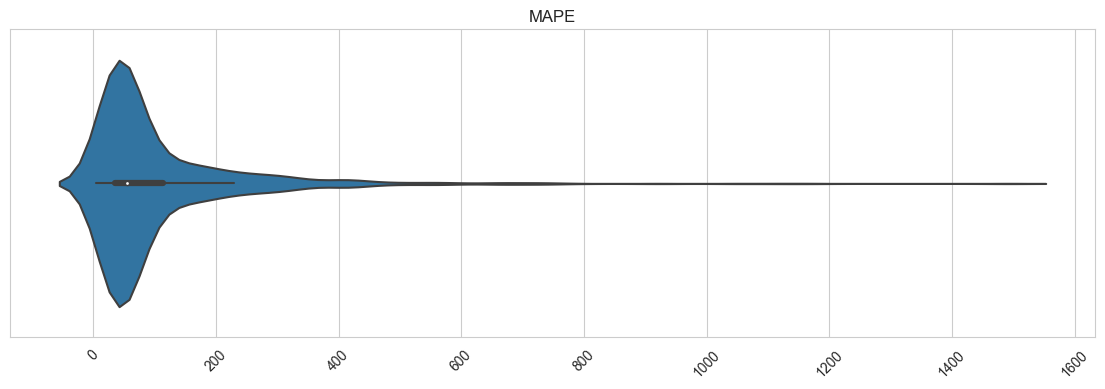

In [205]:
plt.style.use('default')
def plot_metric_distribution(metrics_df, metric='MAPE', figsize=(14, 4)):
    """Plot the distribution of a given metric using a violin plot."""
    plt.figure(figsize=figsize)
    sns.set_style('whitegrid')
    
    # Create violin plot
    vp = sns.violinplot(x=metrics_df[metric])
    
    # Customize plot
    vp.axes.set_title(metric)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(200))
    vp.set_xlabel(None)
    
    plt.show()
    
plot_metric_distribution(metrics_df)

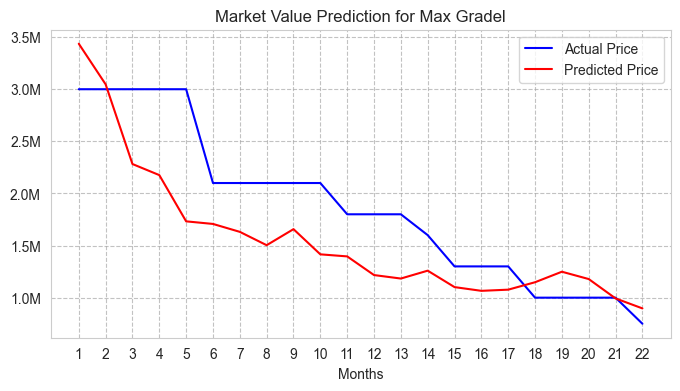

In [275]:
def plot_player_market_value(results, player_id, format_market_value):
    results_player = results[results['player_id'] == player_id]
    name = results.loc[results['player_id'] == player_id, 'name'].iloc[0]
    
    # Create the plot
    plt.figure(figsize=(8, 4))
    plt.plot(results_player.n_month, results_player.real_value, color='blue', label='Actual Price')
    plt.plot(results_player.n_month, results_player.predicted_value, color='red', label='Predicted Price')
    
    # Customize the plot
    plt.xlabel("Months")
    plt.title(f"Market Value Prediction for {name}")
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_market_value))
    plt.xticks(results_player.n_month)
    plt.grid(color='darkgrey', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.show()

player_id = 28140
plot_player_market_value(results, player_id, format_market_value)